***This program is  for 3 class classification by using DarkCovidNet model***

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

**here** i have imported the drive if you want to import this drive then please mail me at bhosale1prathmesh@gmail.com i will share drive instantaneously

In [4]:
from google.colab import drive
drive.mount ('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = Path('/content/drive/MyDrive/upload_by_pratham_xray_multi')

here we are giving path,batch size, train folder validation folder 




In [6]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="train", valid ="val",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  re

data class, train data length ,test data length

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['covid', 'normal', 'pneumonia'], 3, 3000, 1200)

In [8]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 3000
Number of examples in validation: 1200


In [9]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

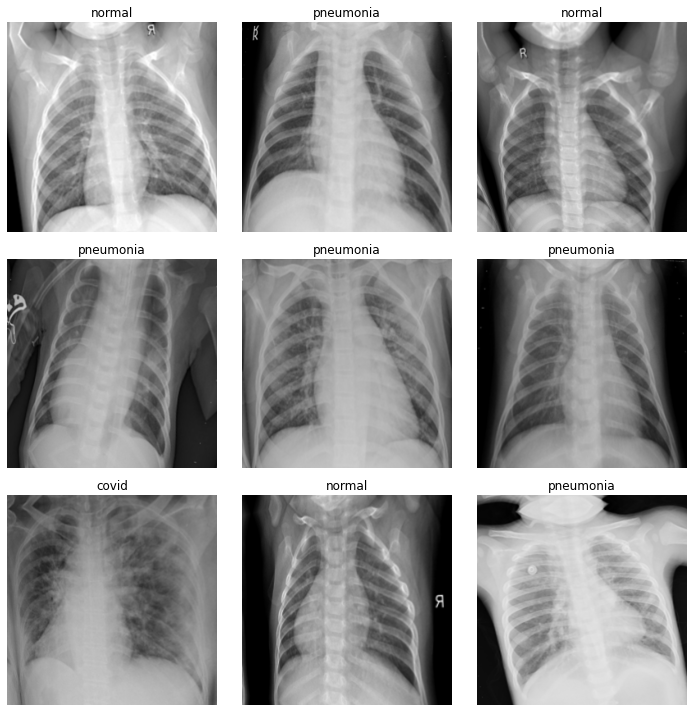

In [10]:
#Sample images from the dataset
data.show_batch(rows=3, figsize=(10,10))

## proposed DarkCovidNet model 

In [11]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [12]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [13]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

**cnn** sequential of model 

In [14]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 3)
)

In [15]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [16]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [17]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.395045,0.292945,0.901667,05:52
1,0.321023,0.222059,0.936667,00:46
2,0.274197,0.271442,0.896667,00:45
3,0.258500,0.275092,0.895000,00:45
4,0.255711,0.285769,0.903333,00:45
5,0.233469,0.324677,0.874167,00:45
6,0.246223,0.238506,0.907500,00:45
7,0.263265,0.219235,0.931667,00:45
8,0.245883,0.241314,0.920833,00:46
9,0.253146,0.221219,0.910000,00:45


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch,train_loss,valid_loss,accuracy,time
0,0.395045,0.292945,0.901667,05:52
1,0.321023,0.222059,0.936667,00:46
2,0.274197,0.271442,0.896667,00:45
3,0.258500,0.275092,0.895000,00:45
4,0.255711,0.285769,0.903333,00:45
5,0.233469,0.324677,0.874167,00:45
6,0.246223,0.238506,0.907500,00:45
7,0.263265,0.219235,0.931667,00:45
8,0.245883,0.241314,0.920833,00:46
9,0.253146,0.221219,0.910000,00:45


**plots of accuracy and losses vs batches processed**

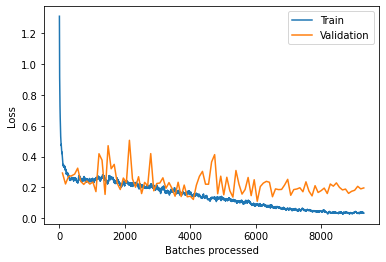

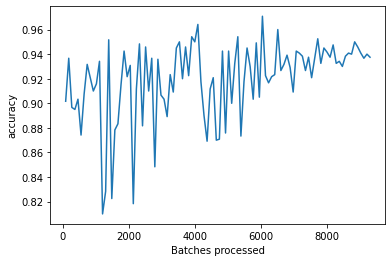

In [18]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()


In [19]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 1200


In [20]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**accuracy**

In [21]:
accuracy(probs,targets)

tensor(0.9375)

In [22]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['covid', 'normal', 'pneumonia'], 3, 3000, 1200)

**precision ,  recall , f1-score**

In [23]:
print(len(probs))
probs = np.argmax(probs, axis=1)

correct = 0 
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

1200
1200 1125 0.9375
[[391   6   3]
 [  0 390  10]
 [  0  56 344]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.98      0.99       400
 No_findings       0.86      0.97      0.92       400
   pneumonia       0.96      0.86      0.91       400

    accuracy                           0.94      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.94      0.94      0.94      1200



In [24]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**confusion matrix** for 3 class 'covid' vs 'no findings'vs'pneumonia'

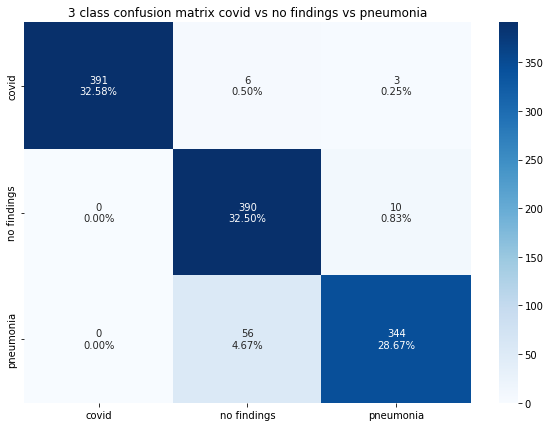

In [25]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.title('3 class confusion matrix covid vs no findings vs pneumonia')

group_counts =[ "{0:0.0f}".format(value) for value in 
                    cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm1.flatten()/np.sum(cm1)]
categories = ['covid' , 'no findings','pneumonia']

labels = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues',xticklabels=categories,yticklabels=categories)
